# 1. Import and Install Dependencies

In [ ]:
# !pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import datetime
import mediapipe as mp

%matplotlib notebook

# 2. Function related to MP Holistic and operation on MP Holistic object

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [6]:
def draw_3D(results, components=['pose', 'face', 'left_hand', 'right_hand']):

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    if results.pose_landmarks:
        keypoint = np.array([[res.x, res.y, res.z] for res in results.pose_landmarks.landmark])
        keypoint[:,1] = [-1*i for i in keypoint[:,1]]
        
        ax.scatter(keypoint[:,0], keypoint[:,2], keypoint[:,1])
        
        for pair in mp_holistic.POSE_CONNECTIONS:
            x_line = np.linspace(keypoint[pair[0],0], keypoint[pair[1],0], 10)
            y_line = np.linspace(keypoint[pair[0],2], keypoint[pair[1],2], 10)
            z_line = np.linspace(keypoint[pair[0],1], keypoint[pair[1],1], 10)
            ax.plot(x_line, y_line, z_line)

    if results.face_landmarks:
        keypoint = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark])
        keypoint[:,1] = [-1*i for i in keypoint[:,1]]
        
        ax.scatter(keypoint[:,0], keypoint[:,2], keypoint[:,1])
        
        for pair in mp_holistic.FACEMESH_TESSELATION:
            x_line = np.linspace(keypoint[pair[0],0], keypoint[pair[1],0], 10)
            y_line = np.linspace(keypoint[pair[0],2], keypoint[pair[1],2], 10)
            z_line = np.linspace(keypoint[pair[0],1], keypoint[pair[1],1], 10)
            ax.plot(x_line, y_line, z_line)
            
    if results.left_hand_landmarks:
        keypoint = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark])
        keypoint[:,1] = [-1*i for i in keypoint[:,1]]
        
        ax.scatter(keypoint[:,0], keypoint[:,2], keypoint[:,1])
        
        for pair in mp_holistic.HAND_CONNECTIONS:
            x_line = np.linspace(keypoint[pair[0],0], keypoint[pair[1],0], 10)
            y_line = np.linspace(keypoint[pair[0],2], keypoint[pair[1],2], 10)
            z_line = np.linspace(keypoint[pair[0],1], keypoint[pair[1],1], 10)
            ax.plot(x_line, y_line, z_line)
            
    if results.right_hand_landmarks:
        keypoint = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark])
        keypoint[:,1] = [-1*i for i in keypoint[:,1]]
        
        ax.scatter(keypoint[:,0], keypoint[:,2], keypoint[:,1])
        
        for pair in mp_holistic.HAND_CONNECTIONS:
            x_line = np.linspace(keypoint[pair[0],0], keypoint[pair[1],0], 10)
            y_line = np.linspace(keypoint[pair[0],2], keypoint[pair[1],2], 10)
            z_line = np.linspace(keypoint[pair[0],1], keypoint[pair[1],1], 10)
            ax.plot(x_line, y_line, z_line)
        
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

# 3. MP Holistic object to keypoints vector

In [7]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    return np.concatenate([pose, face, lh, rh])

# 4. Function draw keypoints in 3D

In [8]:
def display_keypoint_3D(keypoints, components=['pose', 'face', 'left_hand', 'right_hand']):

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    if 'pose' in components:
        pose_keypoints = keypoints[:132]
        pose_keypoints[1::4] = [-1*i for i in pose_keypoints[1::4]]
        
        ax.scatter(pose_keypoints[0::4], pose_keypoints[2::4], pose_keypoints[1::4])
        
        for pair in mp_holistic.POSE_CONNECTIONS:
            x_line = np.linspace(pose_keypoints[pair[0]*4], pose_keypoints[pair[1]*4], 10)
            y_line = np.linspace(pose_keypoints[pair[0]*4+2], pose_keypoints[pair[1]*4+2], 10)
            z_line = np.linspace(pose_keypoints[pair[0]*4+1], pose_keypoints[pair[1]*4+1], 10)
            ax.plot(x_line, y_line, z_line)
            
    if 'face' in components:
        face_keypoints = keypoints[132:1536]
        face_keypoints[1::3] = [-1*i for i in face_keypoints[1::3]]
        
        ax.scatter(face_keypoints[0::3], face_keypoints[2::3], face_keypoints[1::3])
        
        for pair in mp_holistic.FACEMESH_TESSELATION:
            x_line = np.linspace(face_keypoints[pair[0]*3], face_keypoints[pair[1]*3], 10)
            y_line = np.linspace(face_keypoints[pair[0]*3+2], face_keypoints[pair[1]*3+2], 10)
            z_line = np.linspace(face_keypoints[pair[0]*3+1], face_keypoints[pair[1]*3+1], 10)
            ax.plot(x_line, y_line, z_line)
            
    if 'left_hand' in components:
        lh_keypoints = keypoints[1536:1599]
        lh_keypoints[1::3] = [-1*i for i in lh_keypoints[1::3]]
        
        ax.scatter(lh_keypoints[0::3], lh_keypoints[2::3], lh_keypoints[1::3])
        
        for pair in mp_holistic.HAND_CONNECTIONS:
            x_line = np.linspace(lh_keypoints[pair[0]*3], lh_keypoints[pair[1]*3], 10)
            y_line = np.linspace(lh_keypoints[pair[0]*3+2], lh_keypoints[pair[1]*3+2], 10)
            z_line = np.linspace(lh_keypoints[pair[0]*3+1], lh_keypoints[pair[1]*3+1], 10)
            ax.plot(x_line, y_line, z_line)
            
    if 'right_hand' in components:
        rh_keypoints = keypoints[1599:]
        rh_keypoints[1::3] = [-1*i for i in rh_keypoints[1::3]]
        
        ax.scatter(rh_keypoints[0::3], rh_keypoints[2::3], rh_keypoints[1::3])
        
        for pair in mp_holistic.HAND_CONNECTIONS:
            x_line = np.linspace(rh_keypoints[pair[0]*3], rh_keypoints[pair[1]*3], 10)
            y_line = np.linspace(rh_keypoints[pair[0]*3+2], rh_keypoints[pair[1]*3+2], 10)
            z_line = np.linspace(rh_keypoints[pair[0]*3+1], rh_keypoints[pair[1]*3+1], 10)
            ax.plot(x_line, y_line, z_line)
        
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

# 5. Load Data and Create Labels

In [9]:
DATA_PATH = 'E:\Knowledge\_BADs_at_NIDA\BADS7203_Image and video analytics\_Project\SLR\dataset'
actions = os.listdir(os.path.join(DATA_PATH, 'own_keypoints'))

In [10]:
gross_map = {label:num for num, label in enumerate(actions)}
gross_map

{'ขอบคุณ': 0,
 'ขอโทษ': 1,
 'คน': 2,
 'คนชรา': 3,
 'ทารก': 4,
 'น้อง': 5,
 'ปกติ': 6,
 'ผู้ชาย': 7,
 'ผู้หญิง': 8,
 'ผู้ใหญ่': 9,
 'ยิ้ม': 10,
 'ร้องไห้': 11,
 'วัยรุ่น': 12,
 'สนุก': 13,
 'หนุ่มสาว': 14,
 'หิว': 15,
 'เด็ก': 16,
 'เพื่อน': 17,
 'เสียใจ': 18,
 'แฟน': 19,
 'โกรธ': 20}

In [11]:
# load keypoints to numpy array and create list of labels of each
sequences, labels = [], []

for fold in actions:
    file_list = os.listdir(os.path.join(DATA_PATH, 'own_keypoints', fold))
    
    for filename in file_list:
        # load keypoints of each files
        sequence = np.load(os.path.join(DATA_PATH, 'own_keypoints', fold, filename))
        # append in list
        sequences.append(sequence)
        # append labels in same indices
        labels.append(gross_map[fold])
        
#         print(f'{fold}:{filename}: {res.shape} / {sequence.shape} / {gross_map[fold]}')

In [12]:
sequences = np.array(sequences)
sequences.shape

(1050, 30, 1662)

<IPython.core.display.Javascript object>


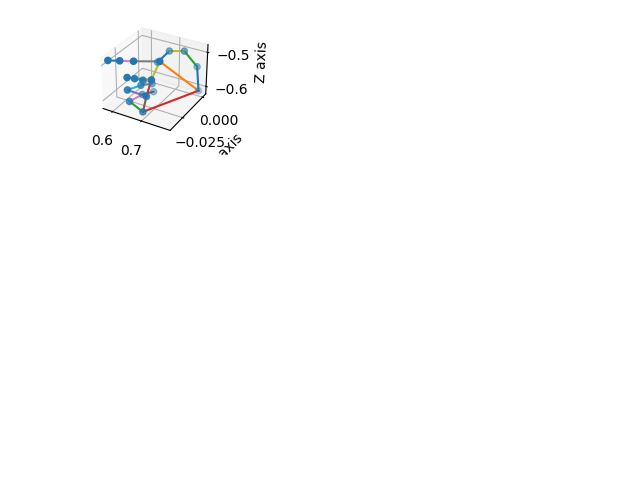

<ipython-input-8-8be8bf1c729a>:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


In [13]:
display_keypoint_3D(keypoints = sequences[500,20,:],
                    components = ['left_hand'])  #['pose', 'face', 'left_hand', 'right_hand']

# 6. Train Test and Validation set

In [14]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [15]:
print(f'Shape of keypoints array: {np.array(sequences).shape}')
print(f'Number of data: {np.array(labels).shape}')

Shape of keypoints array: (1050, 30, 1662)
Number of data: (1050,)


In [16]:
# Define variable X and y
X = np.array(sequences)
y = to_categorical(labels).astype(int)

In [17]:
# Split train and test set (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Split test set to test and validation set (10:10)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [18]:
# proportion after split
print(f'train : validation : test = {y_train.shape[0]} : {y_val.shape[0]} : {y_test.shape[0]}')

train : validation : test = 840 : 105 : 105


# 7. Build and Train RNN Neural Network

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, SimpleRNN, Bidirectional, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import Input

In [35]:
# path to save log model training
log_dir = os.path.join('E:\Knowledge\_BADs_at_NIDA\BADS7203_Image and video analytics\_Project\SLR','Logs','RNN','attempt-1')

# save log model training with tensorboard
tb_callback = TensorBoard(log_dir=log_dir)

---
Simple RNN

In [22]:
model = Sequential()
model.add(Input(shape=(30,1662)))
model.add(SimpleRNN(128, return_sequences=True, activation='relu'))
model.add(SimpleRNN(256, return_sequences=False, activation='relu'))
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(21, activation='softmax'))

Bi-diractional RNN

In [36]:
model = Sequential()
model.add(Input(shape=(30,1662)))
model.add(Bidirectional(SimpleRNN(128, return_sequences=True, activation='relu')))
model.add(Bidirectional(SimpleRNN(256, return_sequences=False, activation='relu')))
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(21, activation='softmax'))

---
GRU

In [20]:
model = Sequential()
model.add(GRU(128, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(GRU(256, return_sequences=False, activation='relu'))
model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(21, activation='softmax'))

Bi-GRU

In [269]:
model = Sequential()
model.add(Input(shape=(50,1662)))
model.add(Bidirectional(GRU(128, return_sequences=True, activation='relu')))
model.add(Bidirectional(GRU(256, return_sequences=False, activation='relu')))
model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(21, activation='softmax'))

---
LSTM

In [71]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, activation='relu', input_shape=(50,1662)))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(21, activation='softmax'))

Bi-LSTM

In [265]:
model = Sequential()
model.add(Input(shape=(50,1662)))
model.add(Bidirectional(SimpleRNN(32, return_sequences=True, activation='relu')))
model.add(Bidirectional(LSTM(64, return_sequences=False, activation='relu')))
model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(21, activation='softmax'))

---
Compiler and summery

In [23]:
model.compile(optimizer='Adam', 
              loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 30, 128)           229248    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 256)               98560     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 21)               

---
Train model

In [36]:
st = time.time()
model.fit(X_train, y_train, epochs=800, validation_data=(X_val, y_val), callbacks=[tb_callback])
end = time.time() - st
print(end)

Epoch 1/800
27/27 [==============================] - 8s 308ms/step - loss: 0.6774 - categorical_accuracy: 0.7405 - val_loss: 2.4564 - val_categorical_accuracy: 0.5143
Epoch 2/800
27/27 [==============================] - 2s 73ms/step - loss: 0.6409 - categorical_accuracy: 0.7464 - val_loss: 2.5183 - val_categorical_accuracy: 0.5333
Epoch 3/800
27/27 [==============================] - 2s 80ms/step - loss: 0.6582 - categorical_accuracy: 0.7226 - val_loss: 2.4718 - val_categorical_accuracy: 0.5143
Epoch 4/800
27/27 [==============================] - 2s 68ms/step - loss: 0.6644 - categorical_accuracy: 0.7250 - val_loss: 2.4621 - val_categorical_accuracy: 0.5333
Epoch 5/800
27/27 [==============================] - 2s 82ms/step - loss: 0.6428 - categorical_accuracy: 0.7262 - val_loss: 2.2292 - val_categorical_accuracy: 0.4667
Epoch 6/800
27/27 [==============================] - 2s 92ms/step - loss: 0.6037 - categorical_accuracy: 0.7548 - val_loss: 2.4937 - val_categorical_accuracy: 0.4762
Epo

27/27 [==============================] - 2s 71ms/step - loss: 0.5122 - categorical_accuracy: 0.8048 - val_loss: 2.6370 - val_categorical_accuracy: 0.5238
Epoch 100/800
27/27 [==============================] - 2s 70ms/step - loss: 0.4405 - categorical_accuracy: 0.8167 - val_loss: 2.5674 - val_categorical_accuracy: 0.5429
Epoch 101/800
27/27 [==============================] - 2s 71ms/step - loss: 0.5064 - categorical_accuracy: 0.7786 - val_loss: 2.4266 - val_categorical_accuracy: 0.4857
Epoch 102/800
27/27 [==============================] - 2s 72ms/step - loss: 0.4970 - categorical_accuracy: 0.8036 - val_loss: 2.9152 - val_categorical_accuracy: 0.4857
Epoch 103/800
27/27 [==============================] - 2s 73ms/step - loss: 0.5114 - categorical_accuracy: 0.7821 - val_loss: 2.9420 - val_categorical_accuracy: 0.4762
Epoch 104/800
27/27 [==============================] - 2s 71ms/step - loss: 0.4959 - categorical_accuracy: 0.8095 - val_loss: 2.9444 - val_categorical_accuracy: 0.4381
Epoch 

Epoch 148/800
27/27 [==============================] - 2s 71ms/step - loss: 1.5158 - categorical_accuracy: 0.4905 - val_loss: 2.6136 - val_categorical_accuracy: 0.2857
Epoch 149/800
27/27 [==============================] - 2s 70ms/step - loss: 1.4343 - categorical_accuracy: 0.4893 - val_loss: 2.6057 - val_categorical_accuracy: 0.3048
Epoch 150/800
27/27 [==============================] - 2s 71ms/step - loss: 1.5009 - categorical_accuracy: 0.5238 - val_loss: 3.4962 - val_categorical_accuracy: 0.1524
Epoch 151/800
27/27 [==============================] - 2s 70ms/step - loss: 2.3836 - categorical_accuracy: 0.2274 - val_loss: 2.3760 - val_categorical_accuracy: 0.2095
Epoch 152/800
27/27 [==============================] - 2s 71ms/step - loss: 1.8121 - categorical_accuracy: 0.3536 - val_loss: 2.0755 - val_categorical_accuracy: 0.2286
Epoch 153/800
27/27 [==============================] - 2s 71ms/step - loss: 1.6057 - categorical_accuracy: 0.4190 - val_loss: 2.1409 - val_categorical_accuracy:

Epoch 197/800
27/27 [==============================] - 2s 70ms/step - loss: 0.4765 - categorical_accuracy: 0.8071 - val_loss: 2.8836 - val_categorical_accuracy: 0.4476
Epoch 198/800
27/27 [==============================] - 2s 70ms/step - loss: 0.4853 - categorical_accuracy: 0.8095 - val_loss: 2.6598 - val_categorical_accuracy: 0.5238
Epoch 199/800
27/27 [==============================] - 2s 70ms/step - loss: 0.5250 - categorical_accuracy: 0.7964 - val_loss: 3.0560 - val_categorical_accuracy: 0.4952
Epoch 200/800
27/27 [==============================] - 2s 75ms/step - loss: 0.6571 - categorical_accuracy: 0.7512 - val_loss: 2.7658 - val_categorical_accuracy: 0.4857
Epoch 201/800
27/27 [==============================] - 2s 71ms/step - loss: 0.6049 - categorical_accuracy: 0.7762 - val_loss: 2.4848 - val_categorical_accuracy: 0.5048
Epoch 202/800
27/27 [==============================] - 2s 70ms/step - loss: 0.5788 - categorical_accuracy: 0.7762 - val_loss: 2.3556 - val_categorical_accuracy:

Epoch 246/800
27/27 [==============================] - 2s 73ms/step - loss: 1.8532 - categorical_accuracy: 0.3786 - val_loss: 2.5568 - val_categorical_accuracy: 0.1619
Epoch 247/800
27/27 [==============================] - 2s 80ms/step - loss: 1.8856 - categorical_accuracy: 0.3393 - val_loss: 2.3855 - val_categorical_accuracy: 0.2190
Epoch 248/800
27/27 [==============================] - 2s 71ms/step - loss: 1.7964 - categorical_accuracy: 0.3738 - val_loss: 2.3754 - val_categorical_accuracy: 0.2286
Epoch 249/800
27/27 [==============================] - 2s 65ms/step - loss: 1.8164 - categorical_accuracy: 0.3976 - val_loss: 2.4035 - val_categorical_accuracy: 0.2476
Epoch 250/800
27/27 [==============================] - 2s 66ms/step - loss: 1.7872 - categorical_accuracy: 0.3798 - val_loss: 2.1319 - val_categorical_accuracy: 0.2286
Epoch 251/800
27/27 [==============================] - 2s 68ms/step - loss: 1.7639 - categorical_accuracy: 0.3845 - val_loss: 2.1622 - val_categorical_accuracy:

Epoch 295/800
27/27 [==============================] - 2s 65ms/step - loss: 1.3542 - categorical_accuracy: 0.5190 - val_loss: 2.1874 - val_categorical_accuracy: 0.2476
Epoch 296/800
27/27 [==============================] - 2s 66ms/step - loss: 1.3659 - categorical_accuracy: 0.5024 - val_loss: 2.3028 - val_categorical_accuracy: 0.2857
Epoch 297/800
27/27 [==============================] - 2s 66ms/step - loss: 1.3945 - categorical_accuracy: 0.5048 - val_loss: 2.2469 - val_categorical_accuracy: 0.3048
Epoch 298/800
27/27 [==============================] - 2s 65ms/step - loss: 1.3745 - categorical_accuracy: 0.5083 - val_loss: 2.1395 - val_categorical_accuracy: 0.2857
Epoch 299/800
27/27 [==============================] - 2s 66ms/step - loss: 1.3103 - categorical_accuracy: 0.5298 - val_loss: 2.3407 - val_categorical_accuracy: 0.3048
Epoch 300/800
27/27 [==============================] - 2s 68ms/step - loss: 1.3904 - categorical_accuracy: 0.5119 - val_loss: 2.3469 - val_categorical_accuracy:

Epoch 344/800
27/27 [==============================] - 2s 66ms/step - loss: 2.1047 - categorical_accuracy: 0.2738 - val_loss: 2.3282 - val_categorical_accuracy: 0.1905
Epoch 345/800
27/27 [==============================] - 2s 66ms/step - loss: 2.0575 - categorical_accuracy: 0.2833 - val_loss: 2.3381 - val_categorical_accuracy: 0.2190
Epoch 346/800
27/27 [==============================] - 2s 65ms/step - loss: 2.0752 - categorical_accuracy: 0.2810 - val_loss: 2.2934 - val_categorical_accuracy: 0.2476
Epoch 347/800
27/27 [==============================] - 2s 66ms/step - loss: 1.9650 - categorical_accuracy: 0.3179 - val_loss: 2.2750 - val_categorical_accuracy: 0.2381
Epoch 348/800
27/27 [==============================] - 2s 70ms/step - loss: 2.0773 - categorical_accuracy: 0.2738 - val_loss: 2.3295 - val_categorical_accuracy: 0.2381
Epoch 349/800
27/27 [==============================] - 2s 65ms/step - loss: 2.0267 - categorical_accuracy: 0.3036 - val_loss: 2.2188 - val_categorical_accuracy:

Epoch 441/800
27/27 [==============================] - 2s 71ms/step - loss: 1.2256 - categorical_accuracy: 0.5202 - val_loss: 2.2584 - val_categorical_accuracy: 0.4095
Epoch 442/800
27/27 [==============================] - 2s 79ms/step - loss: 1.2640 - categorical_accuracy: 0.5143 - val_loss: 2.2596 - val_categorical_accuracy: 0.3905
Epoch 443/800
27/27 [==============================] - 2s 81ms/step - loss: 1.2401 - categorical_accuracy: 0.5262 - val_loss: 2.2783 - val_categorical_accuracy: 0.3714
Epoch 444/800
27/27 [==============================] - 2s 75ms/step - loss: 1.2476 - categorical_accuracy: 0.5274 - val_loss: 2.4946 - val_categorical_accuracy: 0.4190
Epoch 445/800
27/27 [==============================] - 2s 73ms/step - loss: 1.2746 - categorical_accuracy: 0.5155 - val_loss: 2.6616 - val_categorical_accuracy: 0.3810
Epoch 446/800
27/27 [==============================] - 2s 74ms/step - loss: 1.2626 - categorical_accuracy: 0.5214 - val_loss: 2.2470 - val_categorical_accuracy:

Epoch 490/800
27/27 [==============================] - 2s 87ms/step - loss: 1.0883 - categorical_accuracy: 0.5869 - val_loss: 2.2550 - val_categorical_accuracy: 0.4667
Epoch 491/800
27/27 [==============================] - 2s 87ms/step - loss: 1.0291 - categorical_accuracy: 0.5952 - val_loss: 2.7689 - val_categorical_accuracy: 0.4571
Epoch 492/800
27/27 [==============================] - 2s 77ms/step - loss: 1.0340 - categorical_accuracy: 0.6214 - val_loss: 2.8144 - val_categorical_accuracy: 0.4571
Epoch 493/800
27/27 [==============================] - 2s 90ms/step - loss: 1.2838 - categorical_accuracy: 0.5167 - val_loss: 3.6449 - val_categorical_accuracy: 0.4000
Epoch 494/800
27/27 [==============================] - 2s 88ms/step - loss: 1.1991 - categorical_accuracy: 0.5679 - val_loss: 2.4119 - val_categorical_accuracy: 0.4095
Epoch 495/800
27/27 [==============================] - 2s 86ms/step - loss: 1.1654 - categorical_accuracy: 0.5655 - val_loss: 2.7086 - val_categorical_accuracy:

Epoch 539/800
27/27 [==============================] - 2s 85ms/step - loss: 0.9140 - categorical_accuracy: 0.6440 - val_loss: 2.4982 - val_categorical_accuracy: 0.4952
Epoch 540/800
27/27 [==============================] - 2s 83ms/step - loss: 0.8823 - categorical_accuracy: 0.6583 - val_loss: 2.1231 - val_categorical_accuracy: 0.4762
Epoch 541/800
27/27 [==============================] - 2s 79ms/step - loss: 0.9506 - categorical_accuracy: 0.6226 - val_loss: 2.4300 - val_categorical_accuracy: 0.4571
Epoch 542/800
27/27 [==============================] - 3s 94ms/step - loss: 1.2628 - categorical_accuracy: 0.5429 - val_loss: 1.9793 - val_categorical_accuracy: 0.4286
Epoch 543/800
27/27 [==============================] - 2s 71ms/step - loss: 1.1219 - categorical_accuracy: 0.5857 - val_loss: 2.9539 - val_categorical_accuracy: 0.3619
Epoch 544/800
27/27 [==============================] - 2s 75ms/step - loss: 1.2602 - categorical_accuracy: 0.5524 - val_loss: 3.1202 - val_categorical_accuracy:

Epoch 588/800
27/27 [==============================] - 2s 86ms/step - loss: 0.7691 - categorical_accuracy: 0.7083 - val_loss: 2.6206 - val_categorical_accuracy: 0.5333
Epoch 589/800
27/27 [==============================] - 3s 95ms/step - loss: 0.9196 - categorical_accuracy: 0.6476 - val_loss: 2.7177 - val_categorical_accuracy: 0.4762
Epoch 590/800
27/27 [==============================] - 2s 84ms/step - loss: 0.9033 - categorical_accuracy: 0.6393 - val_loss: 2.7234 - val_categorical_accuracy: 0.4381
Epoch 591/800
27/27 [==============================] - 2s 87ms/step - loss: 0.8763 - categorical_accuracy: 0.6345 - val_loss: 2.6578 - val_categorical_accuracy: 0.4667
Epoch 592/800
27/27 [==============================] - 2s 87ms/step - loss: 0.9995 - categorical_accuracy: 0.6405 - val_loss: 2.5346 - val_categorical_accuracy: 0.4095
Epoch 593/800
27/27 [==============================] - 2s 86ms/step - loss: 0.9644 - categorical_accuracy: 0.6393 - val_loss: 2.2493 - val_categorical_accuracy:

Epoch 637/800
27/27 [==============================] - 2s 87ms/step - loss: 0.6843 - categorical_accuracy: 0.7143 - val_loss: 2.7548 - val_categorical_accuracy: 0.4762
Epoch 638/800
27/27 [==============================] - 2s 77ms/step - loss: 0.7845 - categorical_accuracy: 0.7012 - val_loss: 2.9421 - val_categorical_accuracy: 0.5143
Epoch 639/800
27/27 [==============================] - 2s 76ms/step - loss: 0.7025 - categorical_accuracy: 0.7250 - val_loss: 2.7913 - val_categorical_accuracy: 0.5429
Epoch 640/800
27/27 [==============================] - 2s 80ms/step - loss: 0.7646 - categorical_accuracy: 0.6988 - val_loss: 3.1268 - val_categorical_accuracy: 0.4762
Epoch 641/800
27/27 [==============================] - 2s 90ms/step - loss: 0.8988 - categorical_accuracy: 0.6750 - val_loss: 2.7949 - val_categorical_accuracy: 0.4571
Epoch 642/800
27/27 [==============================] - 2s 80ms/step - loss: 0.9955 - categorical_accuracy: 0.6488 - val_loss: 2.1906 - val_categorical_accuracy:

Epoch 686/800
27/27 [==============================] - 2s 68ms/step - loss: 0.7550 - categorical_accuracy: 0.7214 - val_loss: 2.6072 - val_categorical_accuracy: 0.4762
Epoch 687/800
27/27 [==============================] - 2s 67ms/step - loss: 0.8017 - categorical_accuracy: 0.6798 - val_loss: 2.7941 - val_categorical_accuracy: 0.4667
Epoch 688/800
27/27 [==============================] - 2s 69ms/step - loss: 0.8212 - categorical_accuracy: 0.6917 - val_loss: 2.4895 - val_categorical_accuracy: 0.4952
Epoch 689/800
27/27 [==============================] - 2s 69ms/step - loss: 0.6044 - categorical_accuracy: 0.7643 - val_loss: 2.3345 - val_categorical_accuracy: 0.5429
Epoch 690/800
27/27 [==============================] - 2s 67ms/step - loss: 0.6085 - categorical_accuracy: 0.7619 - val_loss: 2.4471 - val_categorical_accuracy: 0.5238
Epoch 691/800
27/27 [==============================] - 2s 68ms/step - loss: 0.7003 - categorical_accuracy: 0.7393 - val_loss: 2.3766 - val_categorical_accuracy:

Epoch 735/800
27/27 [==============================] - 2s 67ms/step - loss: 0.7413 - categorical_accuracy: 0.7321 - val_loss: 2.7312 - val_categorical_accuracy: 0.4286
Epoch 736/800
27/27 [==============================] - 2s 67ms/step - loss: 0.7619 - categorical_accuracy: 0.7238 - val_loss: 2.4863 - val_categorical_accuracy: 0.5238
Epoch 737/800
27/27 [==============================] - 2s 68ms/step - loss: 0.9313 - categorical_accuracy: 0.6750 - val_loss: 2.2806 - val_categorical_accuracy: 0.4667
Epoch 738/800
27/27 [==============================] - 2s 72ms/step - loss: 0.6711 - categorical_accuracy: 0.7440 - val_loss: 2.4752 - val_categorical_accuracy: 0.5238
Epoch 739/800
27/27 [==============================] - 2s 74ms/step - loss: 0.5615 - categorical_accuracy: 0.7929 - val_loss: 2.0934 - val_categorical_accuracy: 0.5333
Epoch 740/800
27/27 [==============================] - 2s 72ms/step - loss: 0.5558 - categorical_accuracy: 0.7964 - val_loss: 2.0908 - val_categorical_accuracy:

Epoch 784/800
27/27 [==============================] - 2s 68ms/step - loss: 0.5190 - categorical_accuracy: 0.8095 - val_loss: 2.2144 - val_categorical_accuracy: 0.5048
Epoch 785/800
27/27 [==============================] - 2s 69ms/step - loss: 0.4873 - categorical_accuracy: 0.8310 - val_loss: 2.2399 - val_categorical_accuracy: 0.5714
Epoch 786/800
27/27 [==============================] - 2s 68ms/step - loss: 0.4945 - categorical_accuracy: 0.8155 - val_loss: 2.1758 - val_categorical_accuracy: 0.5429
Epoch 787/800
27/27 [==============================] - 2s 68ms/step - loss: 0.5061 - categorical_accuracy: 0.8143 - val_loss: 2.2471 - val_categorical_accuracy: 0.4762
Epoch 788/800
27/27 [==============================] - 2s 67ms/step - loss: 0.4710 - categorical_accuracy: 0.8179 - val_loss: 2.4314 - val_categorical_accuracy: 0.5524
Epoch 789/800
27/27 [==============================] - 2s 67ms/step - loss: 0.5208 - categorical_accuracy: 0.8143 - val_loss: 2.4581 - val_categorical_accuracy:

# 8. Make Predictions

In [26]:
res = model.predict(X_test)

In [27]:
for i in range(len(y_test)):
    print(f'actual: {actions[np.argmax(y_test[i])]}, predict: {actions[np.argmax(res[i])]}')

actual: คนชรา, predict: คนชรา
actual: ขอโทษ, predict: ขอบคุณ
actual: ปกติ, predict: ขอโทษ
actual: โกรธ, predict: คนชรา
actual: โกรธ, predict: โกรธ
actual: ขอบคุณ, predict: ขอบคุณ
actual: ผู้ใหญ่, predict: ผู้ชาย
actual: น้อง, predict: แฟน
actual: น้อง, predict: แฟน
actual: ผู้ชาย, predict: ผู้ใหญ่
actual: ขอบคุณ, predict: ยิ้ม
actual: สนุก, predict: สนุก
actual: ร้องไห้, predict: หิว
actual: ผู้ใหญ่, predict: ผู้หญิง
actual: แฟน, predict: แฟน
actual: เสียใจ, predict: คนชรา
actual: ปกติ, predict: ปกติ
actual: ผู้ชาย, predict: ผู้หญิง
actual: คน, predict: คน
actual: เสียใจ, predict: เสียใจ
actual: วัยรุ่น, predict: วัยรุ่น
actual: ผู้หญิง, predict: แฟน
actual: ขอบคุณ, predict: ร้องไห้
actual: ขอโทษ, predict: ขอโทษ
actual: หิว, predict: หิว
actual: หิว, predict: เสียใจ
actual: เพื่อน, predict: ยิ้ม
actual: เด็ก, predict: น้อง
actual: วัยรุ่น, predict: สนุก
actual: ปกติ, predict: หนุ่มสาว
actual: เพื่อน, predict: คน
actual: ปกติ, predict: ขอบคุณ
actual: โกรธ, predict: หิว
actual: ผู้ใหญ่, 

# 9. Save Weights

In [89]:
model.save('slr_gru_1.h5')

In [ ]:
del model

In [21]:
model.load_weights('slt_gru_1.h5')

# 10. Evaluation using Confusion Matrix and Accuracy

In [22]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [23]:
yhat = model.predict(X_test)

In [24]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [25]:
# init set for count correct and incorrect prediction
count_predict = {i:np.array([0,0]) for i in actions}

In [26]:
# count prediction
for ind,val in enumerate(yhat):
    if val == ytrue[ind]:
        count_predict[actions[ytrue[ind]]] = count_predict[actions[ytrue[ind]]] + np.array([1,0])
    else:
        count_predict[actions[ytrue[ind]]] = count_predict[actions[ytrue[ind]]] + np.array([0,1])

In [27]:
print('Gross: (Correct, Incorrect)')
accuracy_score(ytrue, yhat)
count_predict

Gross: (Correct, Incorrect)


{'ขอบคุณ': array([6, 0]),
 'ขอโทษ': array([4, 1]),
 'คน': array([6, 1]),
 'คนชรา': array([2, 0]),
 'ทารก': array([6, 0]),
 'น้อง': array([4, 1]),
 'ปกติ': array([8, 0]),
 'ผู้ชาย': array([6, 0]),
 'ผู้หญิง': array([2, 1]),
 'ผู้ใหญ่': array([7, 1]),
 'ยิ้ม': array([2, 1]),
 'ร้องไห้': array([4, 2]),
 'วัยรุ่น': array([4, 1]),
 'สนุก': array([3, 2]),
 'หนุ่มสาว': array([1, 1]),
 'หิว': array([4, 0]),
 'เด็ก': array([2, 1]),
 'เพื่อน': array([6, 0]),
 'เสียใจ': array([4, 0]),
 'แฟน': array([4, 0]),
 'โกรธ': array([7, 0])}

# 11. Test in Real Time

In [30]:
from scipy import stats
from PIL import ImageFont, ImageDraw, Image

In [32]:
# New detection variables
sequence = []
predictions = list(np.full((8), 6))

# Frequency frame to predict
freq_predict_frame = 3

# init count frame for frequency prediction
count_frame = freq_predict_frame

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # extract keypoints and save recenly 30 sequences
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        # prediction logic
        if len(sequence) == 30:
            # predict every n frame
            if count_frame == freq_predict_frame:
                res = model.predict(np.expand_dims(sequence, axis=0))[0]
                # insert to last position and keep only the last 8 values
#                 predictions.append(np.argmax(res))
#                 predictions = predictions[-8:]
                
                # insert to first position and keep only the first 8 values
                predictions.insert(0, np.argmax(res))
                predictions = predictions[:8]
                print(predictions)
                
                count_frame -= 1
            else:
                count_frame -= 1
                if count_frame == -1:
                    count_frame = freq_predict_frame
            
            
            prediction = stats.mode(predictions)[0][0]
            
            # actions index=6 is normal pose, should not be displayed
            if prediction == 6:
                text = ''
            else:
                text = str(actions[prediction])
            
            # set Thai font
            font = ImageFont.truetype("./angsau.ttf", int(image.shape[0]*0.16))
            
            # draw prediction text on image
            img_pil = Image.fromarray(image)
            draw = ImageDraw.Draw(img_pil)
            draw.text((int(image.shape[1]*0.15),int(image.shape[0]*0.02)),  text, font = font)
            image = np.array(img_pil)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

[13, 6, 6, 6, 6, 6, 6, 6]
6
6
6
6
[13, 13, 6, 6, 6, 6, 6, 6]
6
6
6
6
[13, 13, 13, 6, 6, 6, 6, 6]
6
6
6
6
[13, 13, 13, 13, 6, 6, 6, 6]
6
6
6
6
[13, 13, 13, 13, 13, 6, 6, 6]
13
13
13
13
[13, 13, 13, 13, 13, 13, 6, 6]
13
13
13
13
[13, 13, 13, 13, 13, 13, 13, 6]
13
13
13
13
[13, 13, 13, 13, 13, 13, 13, 13]
13
13
13
13
[6, 13, 13, 13, 13, 13, 13, 13]
13
13
13
13
[13, 6, 13, 13, 13, 13, 13, 13]
13
13
13
13
[13, 13, 6, 13, 13, 13, 13, 13]
13
13
13
13
[13, 13, 13, 6, 13, 13, 13, 13]
13
13
13
13
[13, 13, 13, 13, 6, 13, 13, 13]
13
13
13
13
[13, 13, 13, 13, 13, 6, 13, 13]
13
13
13
13
[13, 13, 13, 13, 13, 13, 6, 13]
13
13
13
13
[13, 13, 13, 13, 13, 13, 13, 6]
13
13
13
13
[13, 13, 13, 13, 13, 13, 13, 13]
13
13
13
13
[13, 13, 13, 13, 13, 13, 13, 13]
13
13
13
13
[13, 13, 13, 13, 13, 13, 13, 13]
13
13
13
13
[13, 13, 13, 13, 13, 13, 13, 13]
13
13
13
13
[6, 13, 13, 13, 13, 13, 13, 13]
13
13
13
13
[6, 6, 13, 13, 13, 13, 13, 13]
13
13
13
13
[6, 6, 6, 13, 13, 13, 13, 13]
13
13
13
13
[6, 6, 6, 6, 13, 13, 13

13
13
13
[13, 13, 2, 19, 2, 13, 13, 13]
13
13
13
13
[13, 13, 13, 2, 19, 2, 13, 13]
13
13
13
13
[13, 13, 13, 13, 2, 19, 2, 13]
13
13
13
13
[13, 13, 13, 13, 13, 2, 19, 2]
13
13
13
13
[6, 13, 13, 13, 13, 13, 2, 19]
13
13
13
13
[6, 6, 13, 13, 13, 13, 13, 2]
13
13
13
13
[6, 6, 6, 13, 13, 13, 13, 13]
13
13
13
13
[6, 6, 6, 6, 13, 13, 13, 13]
6
6
6
6
[6, 6, 6, 6, 6, 13, 13, 13]
6
6
6
6
[13, 6, 6, 6, 6, 6, 13, 13]
6
6
6
6
[13, 13, 6, 6, 6, 6, 6, 13]
6
6
6
6
[13, 13, 13, 6, 6, 6, 6, 6]
6
6
6
6
[13, 13, 13, 13, 6, 6, 6, 6]
6
6
6
6
[13, 13, 13, 13, 13, 6, 6, 6]
13
13
13
13
[13, 13, 13, 13, 13, 13, 6, 6]
13
13
13
13
[13, 13, 13, 13, 13, 13, 13, 6]
13
13
13
13
[13, 13, 13, 13, 13, 13, 13, 13]
13
13
13
13
[13, 13, 13, 13, 13, 13, 13, 13]
13
13
13
13
[13, 13, 13, 13, 13, 13, 13, 13]
13
13
13
13
[13, 13, 13, 13, 13, 13, 13, 13]
13
13
13
13
[13, 13, 13, 13, 13, 13, 13, 13]
13
13
13
13
[13, 13, 13, 13, 13, 13, 13, 13]
13
13
13
13
[13, 13, 13, 13, 13, 13, 13, 13]
13
13
13
13
[13, 13, 13, 13, 13, 13, 13, 1

4
4
[17, 14, 4, 4, 17, 4, 4, 4]
4
4
4
4
[2, 17, 14, 4, 4, 17, 4, 4]
4
4
4
4
[4, 2, 17, 14, 4, 4, 17, 4]
4
4
4
4
[4, 4, 2, 17, 14, 4, 4, 17]
4
4
4
4
[4, 4, 4, 2, 17, 14, 4, 4]
4
4
4
4
[17, 4, 4, 4, 2, 17, 14, 4]
4
4
4
4
[17, 17, 4, 4, 4, 2, 17, 14]
4
4
4
4
[17, 17, 17, 4, 4, 4, 2, 17]
17
17
17
17
[2, 17, 17, 17, 4, 4, 4, 2]
4
4
4
4
[17, 2, 17, 17, 17, 4, 4, 4]
17
17
17
17
[17, 17, 2, 17, 17, 17, 4, 4]
17
17
17
17
[4, 17, 17, 2, 17, 17, 17, 4]
17
17
17
17
[4, 4, 17, 17, 2, 17, 17, 17]
17
17
17
17
[4, 4, 4, 17, 17, 2, 17, 17]
17
17
17
17
[4, 4, 4, 4, 17, 17, 2, 17]
4
4
4
4
[4, 4, 4, 4, 4, 17, 17, 2]
4
4
4
4
[17, 4, 4, 4, 4, 4, 17, 17]
4
4
4
4
[4, 17, 4, 4, 4, 4, 4, 17]
4
4
4
4
[4, 4, 17, 4, 4, 4, 4, 4]
4
4
4
4
[4, 4, 4, 17, 4, 4, 4, 4]
4
4
4
4
[4, 4, 4, 4, 17, 4, 4, 4]
4
4
4
4
[4, 4, 4, 4, 4, 17, 4, 4]
4
4
4
4
[4, 4, 4, 4, 4, 4, 17, 4]
4
4
4
4
[4, 4, 4, 4, 4, 4, 4, 17]
4
4
4
4
[4, 4, 4, 4, 4, 4, 4, 4]
4
4
4
4
[4, 4, 4, 4, 4, 4, 4, 4]
4
4
4
4
[4, 4, 4, 4, 4, 4, 4, 4]
4
4
4
4
[4, 4, 4, 4, 4